In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import yfinance as yf

from invaas.poptions import poptions
from matplotlib.pyplot import figure
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=12, progress_bar=True, verbose=2)

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

data_directory = "data/spy-options-data-2020-2022/"

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
df_formatted = pd.read_csv(raw_data_path, low_memory=False)

columns = df_formatted.columns
columns = [s.replace("[", "") for s in columns]
columns = [s.replace("]", "") for s in columns]
columns = [s.replace(" ", "") for s in columns]
df_formatted.columns = columns

date_columns = ["QUOTE_READTIME", "QUOTE_DATE", "EXPIRE_DATE"]
numeric_cols = df_formatted.columns.to_list()
numeric_cols.remove("QUOTE_READTIME")
numeric_cols.remove("QUOTE_DATE")
numeric_cols.remove("EXPIRE_DATE")

df_formatted.drop(columns=date_columns, inplace=True)

for i in numeric_cols:
    df_formatted[i] = pd.to_numeric(df_formatted[i], errors="coerce")

df_formatted.drop(columns=["C_SIZE", "P_SIZE"], inplace=True)
df_formatted["EXPIRE_UNIX"] = pd.to_datetime(df_formatted.EXPIRE_UNIX, unit="s", utc=True)
df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME, unit="s", utc=True).apply(
    lambda x: pd.Timestamp(x).round(freq="D")
)
df_formatted["OPTION_ID"] = (df_formatted["EXPIRE_UNIX"].astype(str) + df_formatted["STRIKE"].astype(str)).apply(
    lambda x: hash(x)
)

df_formatted.sort_values(by=["QUOTE_UNIXTIME", "EXPIRE_UNIX", "STRIKE"], inplace=True)
df_formatted

,QUOTE_UNIXTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,OPTION_ID
2455495,2020-01-03 00:00:00+00:00,16.0,324.87,2020-01-03 21:00:00+00:00,1.0,1.00000,0.00000,0.00000,-0.00041,0.01423,NaN,1.0,53.48,64.56,64.76,260.0,0.00,0.00,0.03,-0.00049,0.00016,0.00057,-0.00476,0.00000,0.96296,NaN,64.9,0.200,-16219963448717015
2455496,2020-01-03 00:00:00+00:00,16.0,324.87,2020-01-03 21:00:00+00:00,1.0,1.00000,0.00000,0.00000,0.00000,0.01476,NaN,NaN,0.00,59.49,59.73,265.0,0.00,0.02,0.01,-0.00086,0.00017,0.00097,-0.00515,-0.00023,0.88540,1.0,59.9,0.184,-701381295899092907
2455497,2020-01-03 00:00:00+00:00,16.0,324.87,2020-01-03 21:00:00+00:00,1.0,1.00000,0.00000,0.00000,0.00000,0.01467,NaN,NaN,0.00,54.50,54.70,270.0,0.00,0.01,0.01,-0.00109,0.00016,0.00060,-0.00514,0.00000,0.81007,0.0,54.9,0.169,6061307834470536317
2455498,2020-01-03 00:00:00+00:00,16.0,324.87,2020-01-03 21:00:00+00:00,1.0,1.00000,0.00000,0.00000,-0.00042,0.01498,NaN,NaN,0.00,52.00,52.24,272.5,0.00,0.01,0.01,-0.00059,0.00013,0.00058,-0.00510,-0.00028,0.77271,100.0,52.4,0.161,-1220682253960080101
2455499,2020-01-03 00:00:00+00:00,16.0,324.87,2020-01-03 21:00:00+00:00,1.0,1.00000,0.00000,0.00000,-0.00027,0.01538,NaN,1.0,42.41,49.49,49.67,275.0,0.00,0.01,0.01,-0.00115,0.00018,0.00033,-0.00535,0.00000,0.73608,0.0,49.9,0.154,1653060084193980450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975120,2022-12-31 00:00:00+00:00,16.0,382.44,2025-12-19 21:00:00+00:00,1085.0,0.10595,0.00150,1.19348,-0.01204,1.05129,0.17770,2.0,5.71,0.59,10.00,630.0,243.00,250.50,0.00,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,247.6,0.647,8828685382305019902
975121,2022-12-31 00:00:00+00:00,16.0,382.44,2025-12-19 21:00:00+00:00,1085.0,0.09392,0.00140,1.09723,-0.01082,0.94207,0.17304,NaN,0.00,2.00,7.00,635.0,247.66,257.50,0.00,-0.89431,0.00307,0.72687,-0.00434,-0.20330,0.29557,NaN,252.6,0.660,9084648476515366252
975122,2022-12-31 00:00:00+00:00,16.0,382.44,2025-12-19 21:00:00+00:00,1085.0,0.09279,0.00137,1.08956,-0.01114,0.93199,0.17558,NaN,0.00,2.00,7.00,640.0,253.00,262.50,0.00,-0.88536,0.00298,0.78662,-0.00524,-1.78777,0.30289,NaN,257.6,0.673,-5359425724938520695
975123,2022-12-31 00:00:00+00:00,16.0,382.44,2025-12-19 21:00:00+00:00,1085.0,0.09938,0.00147,1.14502,-0.01128,0.99068,0.18239,3.0,4.33,0.12,10.00,645.0,258.00,267.50,0.00,-0.88264,0.00287,0.79928,-0.00538,-1.82985,0.30699,NaN,262.6,0.687,-9164642606529368658


In [3]:
for column in ["C_ASK", "P_ASK"]:
    max_ask_column = f"MAX_{column}_{periods}"
    min_ask_column = f"MIN_{column}_{periods}"
    max_column_rename = {}
    min_column_rename = {}
    max_column_rename[column] = max_ask_column
    min_column_rename[column] = min_ask_column
    df_formatted.drop(columns=[max_ask_column, min_ask_column], errors="ignore", inplace=True)
    df_rolling_max_ask = (
        df_formatted.groupby("OPTION_ID", as_index=False)[column]
        .rolling(window=periods, min_periods=1)
        .max()
        .rename(columns=max_column_rename)
        .drop(columns=["OPTION_ID"])
        .join(df_formatted)[["OPTION_ID", max_ask_column]]
        .groupby("OPTION_ID", as_index=False)
        .shift(periods=-periods)
        .join(df_formatted)[["OPTION_ID", max_ask_column]]
        # .drop(columns=["OPTION_ID"])
    )
    df_rolling_min_ask = (
        df_formatted.groupby("OPTION_ID", as_index=False)[column]
        .rolling(window=periods, min_periods=1)
        .min()
        .rename(columns=min_column_rename)
        .drop(columns=["OPTION_ID"])
        .join(df_formatted)[["OPTION_ID", min_ask_column]]
        .groupby("OPTION_ID", as_index=False)
        .shift(periods=-periods)
        .join(df_formatted)[["OPTION_ID", min_ask_column]]
        .drop(columns=["OPTION_ID"])
    )
    # df_formatted = df_formatted.join(df_rolling_max_ask)
    # df_formatted = df_formatted.join(df_rolling_min_ask)
    break

df_rolling_max_ask

NameError: name 'df_formatted' is not defined

In [ ]:
def rolling_idmax(series, n):
    # fist compute the index in the sliding window
    ids = series.rolling(n).apply(np.argmax)
    # 0 <= ids <= n-1

    # how many rows have past from the sliding window maximum?
    ids = n - 1 - ids
    # 0 <= ids <= n-1

    # subtract `ids` from the actual positions
    ids = np.arange(len(series)) - ids
    # 0 <= ids <= len(series)-1

    # convert the positions stored in `ids` with the corrisponding dates (series.index)
    ids.loc[~ids.isna()] = series.index[ids.dropna().astype(int)]
    # "2005-06-10" <= ids <= "2022-03-04"

    return ids


# df_rolling_max_ask[column + "_INDEX"] = df_formatted.groupby("OPTION_ID", as_index=False)[column].apply(rolling_idmax, periods)
# df_rolling_max_ask

results = df_formatted.groupby("OPTION_ID", as_index=False)[column].apply(rolling_idmax, periods)
results

0      2457398          NaN
       2461126          NaN
       2464767          NaN
       2468382          NaN
       2472066          NaN
                    ...    
74288  3322270    3317557.0
       3326933    3317557.0
       3331689    3317557.0
       3336433    3317557.0
       3341238    3317557.0
Name: C_ASK, Length: 3589079, dtype: float64

In [2]:
# periods = 20
periods = 30  # BEST RESULT
fear_greed_window = 20  # BEST RESULT

refresh_formatted_data = False
refresh_processed_data = False

raw_data_path = data_directory + "spy_2020_2022.csv"
formatted_data_path = data_directory + f"spy_2020_2022_formatted_{periods}_{fear_greed_window}.csv"
processed_data_path = data_directory + f"spy_2020_2022_processed_{periods}_{fear_greed_window}.csv"

if not refresh_processed_data and os.path.isfile(processed_data_path):
    df_options = pd.read_csv(processed_data_path, low_memory=False)
else:
    if not refresh_formatted_data and os.path.isfile(formatted_data_path):
        df_formatted = pd.read_csv(formatted_data_path, low_memory=False)
    else:
        df_formatted = pd.read_csv(raw_data_path, low_memory=False)

        columns = df_formatted.columns
        columns = [s.replace("[", "") for s in columns]
        columns = [s.replace("]", "") for s in columns]
        columns = [s.replace(" ", "") for s in columns]
        df_formatted.columns = columns

        date_columns = ["QUOTE_READTIME", "QUOTE_DATE", "EXPIRE_DATE"]
        numeric_cols = df_formatted.columns.to_list()
        numeric_cols.remove("QUOTE_READTIME")
        numeric_cols.remove("QUOTE_DATE")
        numeric_cols.remove("EXPIRE_DATE")

        df_formatted.drop(columns=date_columns, inplace=True)

        for i in numeric_cols:
            df_formatted[i] = pd.to_numeric(df_formatted[i], errors="coerce")

        df_formatted.drop(columns=["C_SIZE", "P_SIZE"], inplace=True)
        df_formatted["EXPIRE_UNIX"] = pd.to_datetime(df_formatted.EXPIRE_UNIX, unit="s", utc=True)
        df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME, unit="s", utc=True).apply(
            lambda x: pd.Timestamp(x).round(freq="D")
        )
        df_formatted["OPTION_ID"] = (
            df_formatted["EXPIRE_UNIX"].astype(str) + df_formatted["STRIKE"].astype(str)
        ).apply(lambda x: hash(x))

        df_formatted.sort_values(by=["QUOTE_UNIXTIME", "EXPIRE_UNIX", "STRIKE"], inplace=True)

        for column in ["C_ASK", "P_ASK"]:
            max_ask_column = f"MAX_{column}_{periods}"
            min_ask_column = f"MIN_{column}_{periods}"
            max_column_rename = {}
            min_column_rename = {}
            max_column_rename[column] = max_ask_column
            min_column_rename[column] = min_ask_column
            df_formatted.drop(columns=[max_ask_column, min_ask_column], errors="ignore", inplace=True)
            df_rolling_max_ask = (
                df_formatted.groupby("OPTION_ID", as_index=False)[column]
                .rolling(window=periods, min_periods=1)
                .max()
                .rename(columns=max_column_rename)
                .drop(columns=["OPTION_ID"])
                .join(df_formatted)[["OPTION_ID", max_ask_column]]
                .groupby("OPTION_ID", as_index=False)
                .shift(periods=-periods)
                .join(df_formatted)[["OPTION_ID", max_ask_column]]
                .drop(columns=["OPTION_ID"])
            )
            df_rolling_min_ask = (
                df_formatted.groupby("OPTION_ID", as_index=False)[column]
                .rolling(window=periods, min_periods=1)
                .min()
                .rename(columns=min_column_rename)
                .drop(columns=["OPTION_ID"])
                .join(df_formatted)[["OPTION_ID", min_ask_column]]
                .groupby("OPTION_ID", as_index=False)
                .shift(periods=-periods)
                .join(df_formatted)[["OPTION_ID", min_ask_column]]
                .drop(columns=["OPTION_ID"])
            )
            df_formatted = df_formatted.join(df_rolling_max_ask)
            df_formatted = df_formatted.join(df_rolling_min_ask)

        df_formatted_total_options = (
            df_formatted.groupby("OPTION_ID", as_index=False).size().rename(columns={"size": "total"})
        )
        df_formatted = df_formatted.loc[
            df_formatted.OPTION_ID.isin(
                df_formatted_total_options.loc[df_formatted_total_options.total > periods].OPTION_ID
            )
        ]

        with open("data/cnn_fear_greed_index_data.json") as f:
            cnn_fear_greed_index_data = json.load(f)

        df_fear_greed_index = pd.DataFrame(
            data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
        )
        df_fear_greed_index["QUOTE_UNIXTIME"] = pd.DatetimeIndex(
            [pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]
        )
        df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
        df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.astype(float).round().shift()
        df_fear_greed_index[f"fear_greed_index_max_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).max()
        df_fear_greed_index[f"fear_greed_index_min_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).min()
        df_formatted = df_formatted.merge(
            df_fear_greed_index[
                [
                    "QUOTE_UNIXTIME",
                    "fear_greed_index",
                    f"fear_greed_index_max_{fear_greed_window}",
                    f"fear_greed_index_min_{fear_greed_window}",
                ]
            ],
            on="QUOTE_UNIXTIME",
            how="left",
        )

        # df_irx_history = yf.Ticker("^IRX").history(interval="1d", period="5y")
        # df_irx_history.columns = [f"IRX_{x}" for x in map(str.lower, df_irx_history.columns)]
        # df_irx_history["QUOTE_UNIXTIME"] = [
        #     pd.to_datetime(x, utc=True).round(freq="D") for x in df_irx_history.index.values
        # ]
        # df_formatted = df_formatted.merge(
        #     df_irx_history[["QUOTE_UNIXTIME", "IRX_close"]], on="QUOTE_UNIXTIME", how="inner"
        # )

        df_formatted.reset_index(inplace=True, drop=True)
        df_formatted.to_csv(formatted_data_path, index=False)

    def get_options_data(row):
        return [
            {
                "option_id": hash("call" + str(row.OPTION_ID)),
                "option_type": "call",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.C_DELTA,
                "gamma": row.C_GAMMA,
                "vega": row.C_VEGA,
                "theta": row.C_THETA,
                "rho": row.C_RHO,
                "iv": row.C_IV,
                "volume": row.C_VOLUME,
                "last": row.C_LAST,
                "bid": row.C_BID,
                "ask": row.C_ASK,
                "max_ask": row[f"MAX_C_ASK_{periods}"],
                "min_ask": row[f"MIN_C_ASK_{periods}"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
            {
                "option_id": hash("put" + str(row.OPTION_ID)),
                "option_type": "put",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.P_DELTA,
                "gamma": row.P_GAMMA,
                "vega": row.P_VEGA,
                "theta": row.P_THETA,
                "rho": row.P_RHO,
                "iv": row.P_IV,
                "volume": row.P_VOLUME,
                "last": row.P_LAST,
                "bid": row.P_BID,
                "ask": row.P_ASK,
                "max_ask": row[f"MAX_P_ASK_{periods}"],
                "min_ask": row[f"MIN_P_ASK_{periods}"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
        ]

    def flatten(xss):
        return [x for xs in xss for x in xs]

    options_data = flatten(df_formatted[: len(df_formatted)].parallel_apply(get_options_data, axis=1))
    df_options = pd.DataFrame(data=options_data)
    df_options.to_csv(processed_data_path, index=False)

df_options

,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
0,4169629807363267195,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,270.0,54.9,0.169,0.96247,0.00230,0.09124,-0.03148,0.31026,0.30852,10.0,53.85,55.31,55.51,67.91,52.30,NaN,NaN,NaN
1,-1427193746298712266,put,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,270.0,54.9,0.169,-0.01684,0.00147,0.04655,-0.01293,-0.00678,0.25518,NaN,0.00,0.17,0.17,0.23,0.01,NaN,NaN,NaN
2,-880651805349778471,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,275.0,49.9,0.154,0.95833,0.00278,0.10050,-0.03230,0.31394,0.28566,NaN,0.00,50.34,50.53,62.89,47.75,NaN,NaN,NaN
3,1419493114519967095,put,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,275.0,49.9,0.154,-0.02157,0.00193,0.05840,-0.01595,-0.00872,0.24238,1.0,0.28,0.21,0.23,0.30,0.01,NaN,NaN,NaN
4,6851796185238463050,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,280.0,44.9,0.138,0.94983,0.00341,0.11693,-0.03563,0.31725,0.26822,NaN,0.00,45.41,45.66,57.90,42.79,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5183441,8337812745454405911,put,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,590.0,207.6,0.543,-0.87442,0.00305,0.81016,-0.00808,-1.71905,0.29992,0.0,193.26,205.00,212.60,NaN,NaN,37.0,61.0,36.0
5183442,7184827014735111024,call,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,595.0,212.6,0.556,0.08891,0.00157,0.88126,-0.01276,0.62712,0.18258,0.0,6.80,2.00,5.50,NaN,NaN,37.0,61.0,36.0
5183443,5837551170542630138,put,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,595.0,212.6,0.556,-0.86806,0.00287,0.84727,-0.00847,-1.81885,0.30789,NaN,0.00,210.50,217.50,NaN,NaN,37.0,61.0,36.0
5183444,-5828408511425543838,call,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,600.0,217.6,0.569,0.07545,0.00142,0.77750,-0.01128,0.53365,0.17619,12.0,2.55,2.50,3.45,NaN,NaN,37.0,61.0,36.0


<Axes: xlabel='quote_unixtime'>

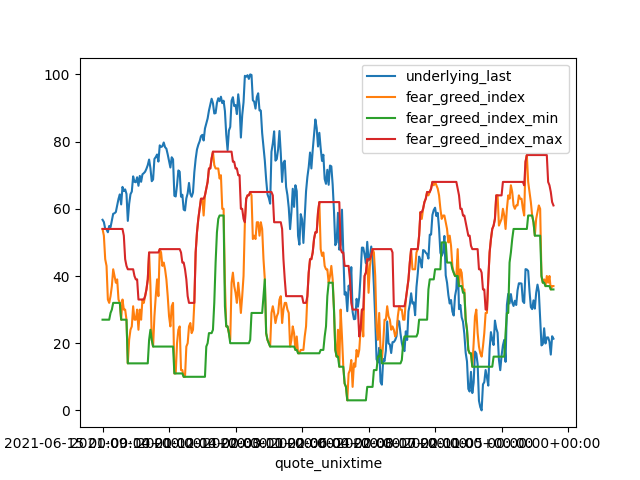

In [3]:
plot_columns = ["underlying_last", "fear_greed_index", "fear_greed_index_min", "fear_greed_index_max"]
df_plot = df_options[["quote_unixtime"] + plot_columns].dropna().drop_duplicates()
df_plot["underlying_last"] = (
    (df_plot.underlying_last - df_plot.underlying_last.min())
    / (df_plot.underlying_last.max() - df_plot.underlying_last.min())
    * 100
)
df_plot.plot(x="quote_unixtime", y=plot_columns)

In [4]:
df_options.describe().astype(str)

,option_id,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
count,5183446.0,5183446.0,5183446.0,5183446.0,5183446.0,5183446.0,5183304.0,5183304.0,5183304.0,5183304.0,5183304.0,4995065.0,4329775.0,5182658.0,5182658.0,5182658.0,3867274.0,3867274.0,2379528.0,2261992.0,2261992.0
mean,2.9153602750674164e+16,208.44489484408626,386.81048857073125,366.2309153022912,79.84188649790116,0.20786633641017963,0.061377349813941044,-7.16732997335483,-4.273652451353425,-0.05487317240316212,-0.17676348886926183,0.325085603106266,189.24003302712035,29.880180199040723,46.262370376358945,47.367116543287295,61.246274471371805,43.06805268258725,39.16426030708611,53.758274122985405,23.277542095639596
std,5.333079846337141e+18,214.28945070866197,55.93111870637418,117.85477394158923,74.10176115308039,0.18785161249208368,0.6097005475830474,8263.766206348793,68.27349741470688,0.2449836036545431,5.614262441778176,0.38684982574298166,2345.348596510615,48.49748971584839,62.023225396788206,62.76557232391271,70.05371023332876,60.47939211854961,16.715752079266753,13.948223468921501,13.246103688851774
min,-9.222950070327091e+18,0.0,222.21,5.0,0.0,0.0,-1.0,-14950363.96601,-2815.39969,-45.23137,-2878.27141,-0.0005,0.0,0.0,0.0,0.0,0.01,0.0,3.0,22.0,3.0
25%,-4.5774401300695813e+18,45.0,342.52,291.0,25.2,0.066,-0.34575,0.00073,0.12985,-0.06511,-0.33982,0.18796,0.0,0.25,3.03,3.41,8.73,2.36,27.0,44.0,14.0
50%,2.6382816117148668e+16,140.0,393.48,365.0,58.5,0.155,0.0,0.0029,0.42276,-0.03984,0.0,0.25137,2.0,8.9,20.37,21.31,34.95,16.28,37.0,54.0,19.0
75%,4.628489213047513e+18,290.0,434.01,440.0,115.4,0.303,0.65371,0.00578,0.87945,-0.01762,0.2984,0.34917,22.0,37.32,64.72,66.5,90.53,59.43,53.0,65.0,29.0
max,9.223256556356517e+18,1096.0,477.77,4898.0,4469.3,10.425,1.0,10.99989,147.32807,0.0,357.46355,52.10104,381807.0,444.2,4451.19,4455.5,4455.5,4455.5,77.0,77.0,58.0


In [5]:
# min_dte = periods
# min_dte = 20
# max_dte = 30
min_dte = 30  # BEST RESULT
max_dte = 90  # BEST RESULT
max_ask = 10
# min_ask = max_ask / 10
min_ask = 0.1
min_volume = 100
max_strike_distance_pct = 0.1
target_profit = 1.2

df_options_filtered = df_options.loc[
    (df_options.fear_greed_index_max.notnull())
    & (df_options.bid > 0)
    & (df_options.ask > 0)
    & (df_options.ask < max_ask)
    & (df_options.ask > min_ask)
    & (df_options.volume > min_volume)
    & (df_options.strike_distance_pct < max_strike_distance_pct)
    & (df_options.days_to_expire > min_dte)
    & (df_options.days_to_expire < max_dte)
]
# [
#     [
#         "option_type",
#         "underlying_last",
#         "strike",
#         "ask",
#         "days_to_expire",
#         "iv",
#         # "irx",
#     ]
# ].drop_duplicates()


# def get_pop(row):
#     # if (row.underlying_last * row.strike * row.ask * row.days_to_expire * row.iv) == 0:
#     #     return 0

#     pop_func = poptions.longCall if row.option_type == "call" else poptions.longPut
#     pop_data = pop_func(
#         underlying=row.underlying_last,
#         long_strike=row.strike,
#         long_price=row.ask,
#         days_to_expiration=int(row.days_to_expire),
#         closing_days_array=[(periods if periods < row.days_to_expire else int(row.days_to_expire))],
#         sigma=row.iv * 100,
#         rate=0,
#         # rate=row.irx,
#         trials=100,
#         multiple_array=[target_profit],
#     )
#     # print(pop_data)
#     return {"pop": pop_data["pop"][0], "pop_error": pop_data["pop_error"][0]}


# # pops = []
# # num = 0
# # total = len(df_options_filtered)

# # for index, row in df_options_filtered.iterrows():
# #     num += 1
# #     print(f"{num}/{total} -- ({num/total*100:.2f}%)", end="\r")
# #     pops.append(get_pop(row))

# # df_options_filtered["pop"] = pops

# pops = df_options_filtered.parallel_apply(get_pop, axis=1)
# df_options_filtered["probability_of_profit"] = [x["pop"] for x in pops]
# df_options_filtered["probability_of_profit_error"] = [x["pop_error"] for x in pops]

df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)
df_options_filtered

/tmp/ipykernel_61923/1226587918.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)


,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
3217819,3008663547997449213,put,2021-06-15 00:00:00+00:00,2021-07-16 20:00:00+00:00,32.0,425.33,385.0,40.3,0.095,-0.07572,0.00487,0.18310,-0.06656,-0.03038,0.22962,3686.0,1.08,1.03,1.04,1.97,0.03,54.0,54.0,27.0
3217821,-6871348143934581290,put,2021-06-15 00:00:00+00:00,2021-07-16 20:00:00+00:00,32.0,425.33,386.0,39.3,0.092,-0.07912,0.00508,0.18874,-0.06780,-0.03140,0.22702,121.0,1.22,1.06,1.08,2.06,0.03,54.0,54.0,27.0
3217825,-7643848508642364201,put,2021-06-15 00:00:00+00:00,2021-07-16 20:00:00+00:00,32.0,425.33,388.0,37.3,0.088,-0.08590,0.00551,0.19974,-0.07036,-0.03406,0.22108,2414.0,1.15,1.14,1.15,2.23,0.03,54.0,54.0,27.0
3217827,3936499674942118164,put,2021-06-15 00:00:00+00:00,2021-07-16 20:00:00+00:00,32.0,425.33,389.0,36.3,0.085,-0.08957,0.00576,0.20590,-0.07159,-0.03513,0.21832,243.0,1.21,1.18,1.19,2.34,0.03,54.0,54.0,27.0
3217829,681636405473264716,put,2021-06-15 00:00:00+00:00,2021-07-16 20:00:00+00:00,32.0,425.33,390.0,35.3,0.083,-0.09293,0.00601,0.21253,-0.07323,-0.03721,0.21591,5567.0,1.25,1.23,1.24,2.39,0.04,54.0,54.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6588412,3074973442818116841,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,437.0,29.6,0.073,0.22074,0.00895,0.56191,-0.06749,0.18591,0.17425,146.0,4.04,4.01,4.05,3.59,0.24,76.0,76.0,54.0
6588414,243829186492752650,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,438.0,30.6,0.075,0.21088,0.00880,0.54746,-0.06536,0.17741,0.17288,127.0,3.83,3.77,3.79,3.37,0.22,76.0,76.0,54.0
6588418,5941774315107753797,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,440.0,32.6,0.080,0.19374,0.00842,0.52021,-0.06182,0.16305,0.17215,111.0,3.40,3.36,3.39,2.94,0.19,76.0,76.0,54.0
6588426,8230302027418419949,call,2022-12-02 00:00:00+00:00,2023-02-17 21:00:00+00:00,78.0,407.40,444.0,36.6,0.090,0.16013,0.00761,0.46192,-0.05323,0.13561,0.16914,173.0,2.61,2.60,2.63,2.26,0.14,76.0,76.0,54.0


In [ ]:
# df_options_filtered.describe().astype(str)
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0]
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0].groupby("option_type", as_index=False).size()

# processed_filtered_data_path = data_directory + "spy_2020_2022_processed_filtered.csv"
# # df_options_filtered.to_csv(processed_filtered_data_path, index=False)
# # df_options_filtered = pd.read_csv(processed_filtered_data_path, low_memory=False)

In [ ]:
# df_options.drop(columns=["probability_of_profit", "probability_of_profit_error"], errors="ignore", inplace=True)
# df_options = df_options.join(df_options_filtered[["probability_of_profit", "probability_of_profit_error"]], how="left")
# df_options

In [ ]:
# df_options["ask_pct_diff"] = (df_options.max_ask - df_options.ask) / df_options.ask
# df_options.describe().astype(str)

# df_options_filtered["max_ask_pct_diff"] = (
#     df_options_filtered.max_ask - df_options_filtered.ask
# ) / df_options_filtered.ask
# df_options_filtered["min_ask_pct_diff"] = (
#     df_options_filtered.min_ask - df_options_filtered.ask
# ) / df_options_filtered.ask
# df_options_filtered.describe().astype(str)

In [34]:
# min_probability_of_profit = 0
# df_options["did_buy"] = (
#     # (df_options.probability_of_profit > min_probability_of_profit)
#     (df_options.fear_greed_index == df_options.fear_greed_index_max)
#     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
#     # (
#     #     ((df_options.option_type == "call") & (df_options.fear_greed_index == df_options.fear_greed_index_max))
#     #     | ((df_options.option_type == "put") & (df_options.fear_greed_index == df_options.fear_greed_index_min))
#     # )
# )
# df_options["should_buy"] = df_options.max_ask > (df_options.ask * target_profit)
# df_options.groupby(["did_buy", "should_buy"], as_index=False).size()
# # df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

min_fear_greed_index_threshold = 30
max_fear_greed_index_threshold = 70
max_diff = 0

df_options_filtered["did_buy"] = (
    (df_options_filtered.option_type == "call")
    & (
        (df_options_filtered.fear_greed_index < min_fear_greed_index_threshold)
        # | (
        #     # (df_options_filtered.fear_greed_index >= min_fear_greed_index_threshold)
        #     # & (df_options_filtered.fear_greed_index <= max_fear_greed_index_threshold)
        #     (df_options_filtered.fear_greed_index <= (df_options_filtered.fear_greed_index_min - max_diff))
        # )
    )
) | (
    (df_options_filtered.option_type == "put")
    & (
        (df_options_filtered.fear_greed_index > max_fear_greed_index_threshold)
        # | (
        #     # (df_options_filtered.fear_greed_index >= min_fear_greed_index_threshold)
        #     # & (df_options_filtered.fear_greed_index <= max_fear_greed_index_threshold)
        #     (df_options_filtered.fear_greed_index >= (df_options_filtered.fear_greed_index_max - max_diff))
        # )
    )
)

# df_options_filtered["did_buy"] = (
#     (df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_min)
# ) | ((df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_max))
df_options_filtered["should_buy"] = df_options_filtered.max_ask > (df_options_filtered.ask * target_profit)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask >= (df_options_filtered.ask * 0.5)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask_pct_diff > 0

total_gains = (
    df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask
    * (target_profit - 1)
    * 100
).sum()
# total_gains = (df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask * (0.5) * 100).sum()

max_loss = -1 if (1 - target_profit) < -1 else (1 - target_profit)
total_losses = (
    df_options_filtered.loc[df_options_filtered.did_buy & (~df_options_filtered.should_buy)].ask * max_loss * 100
).sum()
print(f"Total gains: ${total_gains:.2f}")
print(f"Total losses: ${total_losses:.2f}")
print(f"Total profit: ${total_gains + total_losses:.2f}")
df_options_filtered.groupby(["did_buy", "should_buy"], as_index=False).size()
# df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

Total gains: $577804.00
Total losses: $-54070.80
Total profit: $523733.20


/tmp/ipykernel_61923/1660768581.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["did_buy"] = (
/tmp/ipykernel_61923/1660768581.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["should_buy"] = df_options_filtered.max_ask > (df_options_filtered.ask * target_profit)


,did_buy,should_buy,size
0,False,False,12722
1,False,True,19890
2,True,False,788
3,True,True,6378


In [ ]:
money = 1000
start_money = money
# max_buy_price = max_ask * 100
# min_buy_price = min_ask * 100
contract_fee = 0
max_buy_amount = 1
total_contracts = 1
max_owned_option_type = 100
min_gain_pct = target_profit - 1
# min_gain_pct = 0.1
max_loss_pct = -1 if (1 - target_profit) < -1 else (1 - target_profit)
# max_loss_pct = -1

first_quote_datetime = pd.to_datetime(
    df_options.loc[df_options.fear_greed_index_max.notnull()].quote_unixtime.values[0]
)
last_quote_datetime = pd.to_datetime(df_options.quote_unixtime.values[-1])
last_quote_date = last_quote_datetime.strftime(format="%Y-%m-%d")

# df_options_total = df_options.groupby("option_id", as_index=False).size().rename(columns={"size": "total"})
df_options_simulate = df_options.loc[
    # df_options.option_id.isin(df_options_total.loc[df_options_total.total > 30].option_id)
    (pd.to_datetime(df_options.quote_unixtime) >= first_quote_datetime)
    & df_options.option_id.isin(
        df_options[
            # df_options.probability_of_profit.notna()
            # & (df_options.probability_of_profit >= min_probability_of_profit)
            df_options.fear_greed_index_max.notnull()
            # & (
            #     (df_options.fear_greed_index == df_options.fear_greed_index_max)
            #     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
            # )
            & (
                (
                    (df_options.option_type == "call")
                    & (
                        (df_options.fear_greed_index < min_fear_greed_index_threshold)
                        | (df_options.fear_greed_index <= (df_options.fear_greed_index_min + max_diff))
                    )
                )
                | (
                    (df_options.option_type == "put")
                    & (
                        (df_options.fear_greed_index > max_fear_greed_index_threshold)
                        | (df_options.fear_greed_index >= (df_options.fear_greed_index_max - max_diff))
                    )
                )
            )
            & (df_options.bid > 0)
            & (df_options.ask > 0)
            & (df_options.ask < max_ask)
            & (df_options.ask > min_ask)
            & (df_options.volume > min_volume)
            & (df_options.strike_distance_pct < max_strike_distance_pct)
            & (df_options.days_to_expire > min_dte)
            & (df_options.days_to_expire < max_dte)
        ].option_id
    )
].sort_values(
    by=["quote_unixtime", "expire_unixtime", "ask", "strike_distance_pct"], ascending=[True, True, False, True]
)

owned_options = []
trade_data = []

num = 0
total = len(df_options_simulate)
total_days = (last_quote_datetime - first_quote_datetime).days

for index, row in df_options_simulate.iterrows():
    expire_date = pd.to_datetime(row.expire_unixtime).strftime(format="%Y-%m-%d")
    quote_date = pd.to_datetime(row.quote_unixtime).strftime(format="%Y-%m-%d")
    is_last_quote_date = quote_date == last_quote_date
    num += 1

    if num == total or num % 100 == 0:
        # days_remaining = (last_quote_datetime - pd.to_datetime(row.quote_unixtime)).days
        days_passed = (pd.to_datetime(row.quote_unixtime) - first_quote_datetime).days
        print(
            f"{num/total*100:.2f}% ({num}/{total}) -- {quote_date} ({days_passed}/{total_days}) -- {len(trade_data)} trades",
            end="\r",
        )

    # if row.option_id != -438094404447850621:
    #     continue

    owned_options_not_sold = []
    sold_options = 0

    good_buy = (
        (row.option_type == "call")
        and (
            (row.fear_greed_index < min_fear_greed_index_threshold)
            or (row.fear_greed_index <= (row.fear_greed_index_min + max_diff))
        )
    ) or (
        (row.option_type == "put")
        and (
            (row.fear_greed_index > max_fear_greed_index_threshold)
            or (row.fear_greed_index >= (row.fear_greed_index_max - max_diff))
        )
    )

    for option in owned_options:
        is_option = option["option_id"] == row.option_id
        days_to_expire = (
            option["days_to_expire"]
            - (pd.to_datetime(row.quote_unixtime) - pd.to_datetime(option["quote_unixtime"])).days
        )
        purchase_price = option["ask"] * 100
        bid_price = 0 if not is_option or np.isnan(row.bid) else row.bid * 100
        pct_diff = (bid_price - purchase_price) / purchase_price

        # if is_option and option["option_id"] == -438094404447850621:
        #     print(quote_date, option["days_to_expire"], bid_price, purchase_price, pct_diff, min_gain_pct, max_loss_pct)

        if (
            is_last_quote_date
            or days_to_expire <= 1
            # or (is_option and (not good_buy or (pct_diff > min_gain_pct or pct_diff < max_loss_pct)))
            or (is_option and (pct_diff > min_gain_pct or pct_diff < max_loss_pct))
        ):
            sold_options += 1
            money += (bid_price - contract_fee) * total_contracts
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)-sold_options} sell {option['option_type']} {expire_date} {option['underlying_last']} {option['strike']} ${bid_price:.0f} {option['option_id']}"
            )
            trade_data.append(
                {
                    "id": option["option_id"],
                    "date": quote_date,
                    "money": money,
                    "side": "sell",
                    "type": option["option_type"],
                    "price": bid_price,
                    "options": len(owned_options) - sold_options,
                    "days_to_expire": option["days_to_expire"],
                }
            )
        else:
            owned_options_not_sold.append(option)

    owned_options = owned_options_not_sold

    # max_buy_price = money
    max_buy_price = 1000
    min_buy_price = min_ask * 100

    if (
        # not np.isnan(row.probability_of_profit)
        # and row.probability_of_profit > min_probability_of_profit
        pd.notnull(row.fear_greed_index_max)
        and good_buy
        and not np.isnan(row.ask)
        and row.volume > min_volume
        and row.strike_distance_pct < max_strike_distance_pct
        and row.days_to_expire > min_dte
        and row.days_to_expire < max_dte
        and row.days_to_expire < (last_quote_datetime - pd.to_datetime(row.quote_unixtime)).days
        and len([x for x in owned_options if x["option_id"] == row.option_id]) == 0
        and len([x for x in owned_options if x["option_type"] == "call"]) < max_owned_option_type
        and len([x for x in owned_options if x["option_type"] == "put"]) < max_owned_option_type
        and (len([x for x in owned_options if x["purchase_date"] == quote_date]) < max_buy_amount)
    ):
        ask_price = row.ask * 100

        if ask_price <= max_buy_price and ask_price >= min_buy_price and money >= ask_price:
            money -= (ask_price + contract_fee) * total_contracts
            option_to_buy = row.to_dict()
            option_to_buy["purchase_date"] = quote_date
            owned_options.append(option_to_buy)
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)} buy {row.option_type} {expire_date} {row.underlying_last} {row.strike} ${ask_price:.0f} {row.option_id}"
            )
            trade_data.append(
                {
                    "id": row.option_id,
                    "date": quote_date,
                    "money": money,
                    "side": "buy",
                    "type": row.option_type,
                    "price": ask_price,
                    "options": len(owned_options),
                    "days_to_expire": row.days_to_expire,
                }
            )

print()
print(f"Start money: ${start_money:.2f}")
print(f"End money: ${money:.2f} ({(money-start_money)/start_money*100:.2f}%)")

TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [ ]:
# # "2021-08-17"
# df_options_simulate.loc[(df_options_simulate.option_id == -438094404447850621)][["quote_unixtime", "ask", "bid"]]

In [ ]:
df_trades = pd.DataFrame(trade_data)
# df_trades = df_trades.loc[df_trades["type"] == "call"]

df_trades["diff"] = df_trades.groupby("id")["price"].diff()
df_trades["pct_change"] = df_trades.groupby("id")["price"].pct_change() * 100

field_to_plot = "money"
# df_trades_plot = df_trades_plot.copy()
# df_trades_plot = df_trades.loc[(df_trades["side"] == "sell")]
df_trades_plot = df_trades.loc[(df_trades["side"] == "sell") & (df_trades["options"] == 0)]

# field_to_plot = "options"
# df_trades_plot = df_trades.groupby(["date"]).max("options").reset_index()

fig = figure(figsize=(13, 4), dpi=80)

plt.close(fig)
plt.clf()
plt.plot(pd.to_datetime(df_trades_plot["date"]), df_trades_plot[field_to_plot])
plt.xlabel("date")
plt.ylabel(field_to_plot)
plt.show()

total_trades = len(df_trades.loc[df_trades["side"] == "sell"])
good_trades = (df_trades.dropna()["diff"] > 0).sum()
print(f"Total trades: {total_trades}")
print(f"Good trades: {good_trades} ({good_trades/total_trades*100:.2f}%)")
print(f"Min Diff: ${df_trades['diff'].min():.2f}")
print(f"Max Diff: ${df_trades['diff'].max():.2f}")
print(f"Min Pct. Change: {df_trades['pct_change'].min():.2f}%")
print(f"Max Pct. Change: {df_trades['pct_change'].max():.2f}%")
df_trades.describe().astype(str)